In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import sqlite3
import os
from datetime import datetime
import random as rd
import statistics as st
import time
import scipy as sp

In [7]:
input_acc = pd.read_csv("./instagram_accounts.csv", delimiter=',')
input_post_1 = pd.read_csv("./instagram_posts_0911_1111.csv", delimiter=',')
input_post_2 = pd.read_csv("./instagram_posts_1211_1611.csv", delimiter=',')
input_post = pd.concat([input_post_1, input_post_2], ignore_index=True)
pd.options.display.max_colwidth = 1000

# function which changes the "list" strings to python lists
def str_to_list(str):
    str=str.strip('[')
    str=str.strip(']')
    str = str.split(',')
    L=[]
    for elem in str:
        L.append(int(elem))
    return L

In [8]:
#program which removes one of the users who share the same id_user and remove one to the nb_following of his followers 
pb=None
i=-1
while pb is None:
    i+=1
    if (input_acc['id_user'][i],input_acc['sex'][i] )==(603282,'female'):
        pb=input_acc[i:i+1]
        input_acc=input_acc.drop(i)

pb_str=pb['id_followers'].to_string(index = False)
to_remove = str_to_list(pb_str)
for j in range (len(input_acc['id_user'])):
    if j<i:
        if input_acc['id_user'][j] in to_remove:
            input_acc['nb_following'][j]=input_acc['nb_following'][j]-1
    elif j>=i:
        if input_acc['id_user'][j+1] in to_remove:
            input_acc['nb_following'][j+1]=input_acc['nb_following'][j+1]-1

# program which removes the post from this removed user
      
pb=None
l=-1
while pb is None:
    l+=1
    if (input_post['id_user'][l])==(603282):
        pb=input_post[l:l+1]
        input_post=input_post.drop(l)

C:\Users\Urbain_CS\AppData\Local\Temp\ipykernel_17268\2217277617.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_acc['nb_following'][j]=input_acc['nb_following'][j]-1
C:\Users\Urbain_CS\AppData\Local\Temp\ipykernel_17268\2217277617.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_acc['nb_following'][j+1]=input_acc['nb_following'][j+1]-1


Creation of a graph from the given database extended with a Barabasi-Albert method using a power law for the distribution of the degree of new nodes

In [9]:
def invert_adjacency_list(adjacency_list):
    n = len(adjacency_list)
    inverted_list = [[] for _ in range(n)]
    for personne in range(n):
        for contact in adjacency_list[personne]:
            inverted_list[contact].append(personne)
    return inverted_list
#Here we create the initial graph from the database
input_acc = pd.read_csv("./instagram_accounts.csv", delimiter=',')
input_post = pd.read_csv("./instagram_posts_0911_1111.csv", delimiter=',')

accounts= np.array(input_acc)
posts= np.array(input_post)
# array of id_users and their followers
id=accounts[:,1]
followers=accounts[:,6]
n=len(id)
p=len(posts)
# we rename the id_user between 0 and n-1
index={}
for k in range(n):
    index[id[k]]=k

# auxiliary function to create the adjacency list
def convert_string_id_to_list_index(string):    
    lis=list(string.split(", "))
    lis[0]=int(lis[0][1:])
    lis[-1]=int(lis[-1][:-1])
    for k in range(len(lis)):
        lis[k]=index[int(lis[k])]
    return lis

#adjacency list of the graph such that  list_adjacence[i] gives the index of the followers of i
list_adjacence=invert_adjacency_list([convert_string_id_to_list_index(l) for l in followers])
#initialisation of the list of edges
edges=[]
for i in range(len(list_adjacence)):
#for i in range(10):
    for j in range(len(list_adjacence[i])):
        #an edge i->j means that j is a follower of i
        edges.append((i,list_adjacence[i][j]))

g=ig.Graph(directed=True)
g.add_vertices(n)
g.add_edges(edges)

Here are the functions to compute the value of the KPIs we chose on the initial campaign in the population we considered

In [58]:
def R_u( cursor,i1,i2):
    cursor.execute("Select  id_user from posts ")
    Post = cursor.fetchall()
    cursor.execute("Select id_user from accounts")
    Users = cursor.fetchall()
    R=[]
    for user in Users:
        r1=i1*((user[0],)in Post)
        r3=sum([((id[id_folwing],) in Post) for id_folwing in list_adjacence[index[user[0]]]])
        n_following = len(list_adjacence[index[user[0]]])
        r2=i2*n_following*(r3)/max(1,n_following**2)
        R.append(r1+r2)
    return R

def R_u_mean (cursor, i1,i2):
    res = R_u(cursor, i1,i2)
    s=0.
    for elem in res:
        s+=elem
    return s/(10**6)

def R_g(cursor,i1,i2,i3):
    cursor.execute("Select Count(id_user) from accounts")
    n_users = 10**6
    cursor.execute("Select Count(id_post) from posts where id_post!=0")
    n_repost = cursor.fetchone()[0]
    cursor.execute("Select Count(id_post),Sum(likes),Sum(views),Sum(link_clicks)  from posts")
    n_post, n_like,n_view,n_clique = cursor.fetchone()
    return i1 * n_repost/n_users + i2*n_like/n_view + i3*n_clique/n_post

def Dons_tot(cursor):
    cursor.execute("Select Sum(donation_val) from posts ")
    return cursor.fetchone()

def Dons_par_post(cursor):
    cursor.execute("Select 1.0*Sum(donation_tag)/Count(id_post)from posts")
    return cursor.fetchone()

def taux_conv(cursor):
    cursor.execute("Select 1.0*Sum(donation_val)/Count(id_post)from posts")
    return cursor.fetchone()

In [59]:
conn=sqlite3.connect('./data/instagram_clean.db')
cursor=conn.cursor()
print(R_u_mean(cursor, 0.7,0.3))
# print(R_p_mean(cursor,0.8,0.1,0.1))
print(R_g(cursor, 0.3,0.2,0.5))
print(Dons_tot(cursor))
print(Dons_par_post(cursor))
print(taux_conv(cursor))

0.003046
0.10750435494241065
(755,)
(0.010177281680892974,)
(0.24786605384110308,)


Extension of the graph 

In [10]:
def power_law(a, threshhold = 0.01):
    p=rd.random()
    c = 1/sp.special.zeta(a)
    k=1
    s=c*k**(-a)
    t= time.time()
    while time.time()-t< threshhold and p>s:
        k+=1
        s+=c*k**(-a)
    return k

a = 2.1
n = len(g.vs)
pop = 10**6
rd_g = ig.Graph.Barabasi(pop,[5+power_law(a)%(i+n-5) for i in range(pop-n)],directed = True,start_from = g)

adj_list = rd_g.get_adjlist()

In [11]:
# here we choose the 5 best influencers
list_sort_follow = [(len(adj_list[i]),i) for i in range(len(adj_list))]
list_sort_follow.sort()
print(list_sort_follow[-1:-6:-1])

[(26804, 347009), (25440, 771154), (24491, 702326), (23981, 908809), (22729, 235814)]


We will define the parameters and the counters here

In [12]:
# We found the values of the parameters by trying to fit them to the "expected" results : the one given by the real campaign.
# We tweaked these values until we found something acceptable

# We define a timestep for every hour ( the duration of the experiment is 6 days)
time = 24*8

# The chance of reposting as an exposed person
alpha_r = 0.0115

# The chance of liking, clikcing and donating a post as an exposed person
alpha_l = 0.242
alpha_c = 0.0011

# The chance of becoming exposed (to view the post), if a person follow somebody who reposted
beta = 0.000315

# 1/gamma is the average lifetime of a repost
gamma = 1/time

# 1/eta is the average time sombedy will stay exposed to the post before becoming "bored"
eta = 1/(8*time)

#Parametres pour les dons
omega = 0.00016
omegaprime = omega/10
teta = (alpha_r * beta)/10


Nuser = len(adj_list)

compteurs = { 'likestot' : 0, 'cliquestot' : 0, 'donstot': 0, 'nombredons' :0, 'poststot' : 0, 'viewstot' : 0}

dico_users = {}
for i in range(Nuser):
    dico_users[i] = {'Repost': False, 'Number_of_repost':0}

Here is the main part of the model where we run the simulation.

In [13]:
def maj(list_adj, S0, E0, IR0, P0, ID0, time, INFLUENCEURS_NB):
    # The lists below will help us plot the evolution of the different populations over time
    S_plot = [0] * time
    E_plot = [0] * time
    IR_plot = [0] * time
    ID_plot = [0] * time
    P_plot = [0] * time
    numbers = list_sort_follow[-1:-(1+INFLUENCEURS_NB):-1]
    h = 0

    for t in range(time):
        time_influence= np.linspace(10,120,INFLUENCEURS_NB) # this gives the timing when the influencers should post
        Influencers_id = [numbers[x][1] for x in range(len(numbers))]
        if t in time_influence and len(Influencers_id)>1:
            elt = Influencers_id[h]
            IR0[elt] = 1
            S0[elt] = 0
            for follower in list_adj[elt]:
                if rd.random() < 0.05:
                    if P0[follower]==1:
                        P0[follower]=0
                        E0[follower] = 1
                    elif S0[follower]==1:
                        S0[follower]=0
                        E0[follower] = 1   
                    
            h+=1

        # For each timestep, we will go through every "node", that represent every user in the database
        for node in range(len(S0)):
            count = 0
            # If the user is sane, we will check if he follows people who have reposted
            if S0[node] == 1:
                S_plot[t] += 1
                for contact in list_adj[node]:
                    if IR0[contact] == 1 or ID0[contact] == 1:
                        count += 1
                        # We define here the odds of the person seeing the post
                        if rd.random() < beta:
                            E0[node] = 1
                            S0[node] = 0
                    elif rd.random() < teta:
                            IR0[node] = 1
                            S0[node] = 0
                dico_users[node]['Number_of_repost'] = count
            # If the user is exposed (if he has seen the post), he might become a reposter or like or click or donate
            elif E0[node] == 1:
                E_plot[t] += 1
                compteurs['viewstot'] += 1
                if rd.random() < alpha_r:
                    IR0[node] = 1
                    E0[node] = 0
                    compteurs['poststot'] +=1
                    dico_users[node]['Repost'] = True
                    
                elif rd.random() < omegaprime:
                    ID0[node] = 1
                    E0[node] = 0
                    compteurs['cliquestot'] += 1
                    compteurs['nombredons'] += 1
                    compteurs['donstot'] += rd.randint(5,60) # Amount given per donation, we chose it so the expectancy is the same as the one in the database
                # Here is the probability that the person will not be interested by the post after seeing it
                if rd.random() < eta:
                    if rd.random() < 0.7:
                        E0[node] = 0
                        P0[node] = 1
                    else:
                        E0[node] = 0
                        S0[node] = 1
                else:
                    if rd.random() < alpha_l:
                        compteurs['likestot'] +=1
                    if rd.random() < alpha_c:
                        compteurs['cliquestot'] += 1
                    

            # For the reposter, his post will remain relevant on the platform for a duration of 24 hours
            elif IR0[node] == 1:
                IR_plot[t] += 1
                if rd.random() < gamma:
                    P0[node] = 1
                    IR0[node] = 0
                elif rd.random() < omega:
                    IR0[node] = 0
                    ID0[node] = 1
                    compteurs['cliquestot'] += 1
                    compteurs['nombredons'] += 1
                    compteurs['donstot'] += rd.randint(5,60) # Amount given per donation, we chose it so the expectancy is the same as the one in the database
            elif ID0[node] == 1:
                ID_plot[t] +=1
            else:
                P_plot[t] += 1
    print(Influencers_id)
    return S_plot, E_plot, IR_plot, ID_plot, P_plot
        



We define the initial values according to the database:

In [14]:
S0 = [1] * Nuser
E0 = [0] * Nuser
IR0 = [0] * Nuser
ID0 = [0] * Nuser
P0 = [0] * Nuser

S0[849], IR0[849] = 0, 1
S0[1363], IR0[1363] = 0,1
S0[874], IR0[874] = 0,1
S0[51], IR0[51] = 0,1

In [17]:
def run_model(N):
    # N is the number of influencers we choose
    S0 = [1] * Nuser
    E0 = [0] * Nuser
    IR0 = [0] * Nuser
    ID0 = [0] * Nuser
    P0 = [0] * Nuser

    S0[849], IR0[849] = 0, 1
    S0[1363], IR0[1363] = 0,1
    S0[874], IR0[874] = 0,1
    S0[51], IR0[51] = 0,1
    
    time = 24*8 # We define a timestep for every 20minutes ( the duration of the experiment is 3 days)
    S_plot, E_plot, IR_plot, ID_plot, P_plot = maj(adj_list, S0, E0, IR0,ID0,  P0, time,N)
    return(S_plot, E_plot, IR_plot, ID_plot, P_plot)


Here we run the model and plot the populations on a logarithmic scale

[347009, 771154, 702326, 908809, 235814]


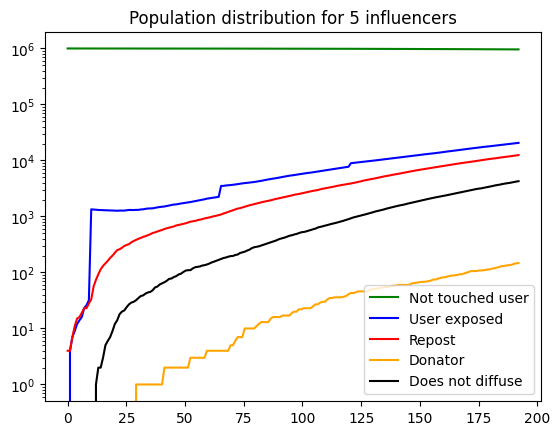

In [18]:
S0[849], IR0[849] = 0, 1
S0[1363], IR0[1363] = 0,1
S0[874], IR0[874] = 0,1
S0[51], IR0[51] = 0,1
L=[]

S_plot, E_plot, IR_plot, ID_plot, P_plot = run_model(5)

time_scale = np.linspace(0, time, time)
plt.plot(time_scale, S_plot,'g',label = 'Not touched user')
plt.plot(time_scale, E_plot,'b',label = 'User exposed')
plt.plot(time_scale, IR_plot,'r',label = 'Repost')
plt.plot(time_scale, ID_plot,color ='orange',label = 'Donator')
plt.plot(time_scale, P_plot,'k', label = 'Does not diffuse')

plt.yscale('log')
plt.title('Population distribution for 5 influencers')
plt.legend()
plt.show()

Print KPIs:

In [19]:
def mean_R_u(dico):
    l = len(dico)
    return(sum(dico)/l)
        
def R_u(dico):
    L=[]
    K = invert_adjacency_list(adj_list)
    for k in dico:
        n = dico[k]['Number_of_repost']
        l = len(K[k])
        if dico[k]['Repost'] and l > 0:
            L.append(0.7+0.3*(n/l))
        else :
            if l>0:
                L.append(0.3*(n/l))
            else:
                L.append(0)
    return(L)

Ru = [mean_R_u(R_u(elt[1])) for elt in L]
# We implemented this dataframe to help us tweak the parameters of the system according to what should be increased.
data = {'Parameter': ['Likes', 'Clicks', 'Dons(nombre)', 'Dons(valeur)', 'Posts', 'Vues'],
        'Expected': [68109,320,31,755,3047, 251167],
        'Measured': [compteurs['likestot'],compteurs['cliquestot'] , compteurs["nombredons"] ,compteurs['donstot'],compteurs['poststot'], compteurs['viewstot']]}

df = pd.DataFrame(data)

In [20]:
def R_G(L):
    R =[]
    for elt in L:
        c = elt[0]
        Rg = 0.3 * c['poststot'] / Nuser + 0.3 * c['likestot'] / c['viewstot'] + 0.4 * c['cliquestot'] / c['poststot']
        R.append(Rg)
    return(R)
Rg = R_G(L)

Multiple simulations:

In [ ]:
n_simul = 10
compteur_moyen = {'likesmoy' : 0, 'cliquesmoy' : 0, 'donsmoy': 0, 'nombredonsmoy' :0, 'postsmoy' : 0, 'viewsmoy' : 0}
for i in range(n_simul):    
    compteurs = { 'likestot' : 0, 'cliquestot' : 0, 'donstot': 0, 'nombredons' :0, 'poststot' : 0, 'viewstot' : 0}
    run_model()
    compteur_moyen['likesmoy'] += compteurs['likestot']
    compteur_moyen['cliquesmoy'] += compteurs['cliquestot']
    compteur_moyen["nombredonsmoy"] += compteurs["nombredons"]
    compteur_moyen['donsmoy'] += compteurs['donstot']
    compteur_moyen['postsmoy'] += compteurs['poststot']
    compteur_moyen['viewsmoy'] += compteurs['viewstot']

for key in compteur_moyen.keys():
    compteur_moyen[key] = compteur_moyen[key]/(n_simul+1)

In [21]:
# We implemented this dataframe to help us tweak the parameters of the system according to what should be increased.
data = {'Parameter': ['Likes', 'Clicks', 'Dons(nombre)', 'Dons(valeur)', 'Posts', 'Vues'],
        'Expected': [68109,320,31,755,3047, 251167],
        'Measured': [compteur_moyen['likesmoy'],compteur_moyen['cliquesmoy'] , compteur_moyen["nombredonsmoy"] ,compteur_moyen['donsmoy'],compteur_moyen['postsmoy'], compteur_moyen['viewsmoy']]}

df = pd.DataFrame(data)

print(df)

NameError: name 'compteur_moyen' is not defined

This part of the code let us build a sequence of images with the propagation of posts through time in the database in the folders : 
- figures for the initial campaign
- fihures2 for our strategy

In [37]:
def convert_time(i):
    day=posts[i,3]
    hour=posts[i,4]
    half_day=posts[i,5]
    jour=0
    if day[:2]=="09":
        jour=0
    if day[:2]=="10":
        jour=1
    if day[:2]=="11":
        jour=2
    if day[:2]=="12":
        jour=3
    if day[:2]=="13":
        jour=4
    if day[:2]=="14":
        jour=5
    if day[:2]=="15":
        jour=6
    if day[:2]=="16":
        jour=7

    heure=int(hour[:2])+int(hour[3:])/60
    if half_day=="pm":
        heure+=12
    heure=heure+jour*24
    return heure

In [38]:
time_l=np.zeros(p)
for i in range(p):
    time_l[i]=convert_time(i)

In [39]:
post_id=posts[:,1]
user_id=posts[:,2]
views=posts[:,6]
reposts=posts[:,7]
likes=posts[:,8]
comments=posts[:,9]
id_post_origin=posts[:,10]
link_clicks=posts[:,11]
donation_tag=posts[:,12]
donation_val=posts[:,13]
house_buy=posts[:,14]


In [40]:
time_modif=[(time_l[i],post_id[i],user_id[i],views[i],reposts[i],likes[i],comments[i],id_post_origin[i],link_clicks[i],donation_tag[i],donation_val[i],house_buy[i]) for i in range(p)]
time_modif.sort()

In [41]:
time_l=[time_modif[i][0] for i in range(p)]
post_id=[time_modif[i][2] for i in range(p)]
user_id=[time_modif[i][1] for i in range(p)]
views=[time_modif[i][3] for i in range(p)]
reposts=[time_modif[i][4] for i in range(p)]
likes=[time_modif[i][5] for i in range(p)]
comments=[time_modif[i][6] for i in range(p)]
id_post_origin=[time_modif[i][7] for i in range(p)]
link_clicks=[time_modif[i][8] for i in range(p)]
donation_tag=[time_modif[i][9] for i in range(p)]
donation_val=[time_modif[i][10] for i in range(p)]
house_buy=[time_modif[i][11] for i in range(p)]

In [42]:
colors=["red" for i in range(n)]
g=ig.Graph(directed=True)
g.add_vertices(n)
g.add_edges(edges)
layout = g.layout("fr")
g.delete_edges(g.get_edgelist())
k=0
for t in range(183):
    try:
        while time_l[k]<t:
            colors[index[user_id[k]]]="green"
            g.vs["color"]=colors
            k+=1

        plot = ig.plot(g,vertex_size=5,layout=layout)
        a="figures/graph"+str(t)+".png"
        plot.save(a)
    except:
        plot = ig.plot(g,vertex_size=5,layout=layout)
        a="figures/graph"+str(t)+".png"
        plot.save(a)

In [55]:
def maj2(list_adj, S0, E0, IR0, P0, ID0, time,individu):
    # The lists below will help us plot the evolution of the different populations over time
    S_plot = [0] * time
    E_plot = [0] * time
    IR_plot = [0] * time
    ID_plot = [0] * time
    P_plot = [0] * time

    i = 0

    for t in range(time):
        time_influence=[60,70,80,90,100]
        numbers = [196644, 676277, 523927, 919964, 819950]
        Influencers_id = [ index[elt] for elt in numbers]
        if t in time_influence:
            elt = Influencers_id[i]
            IR0[elt] = 1
            for k in range(t+1,time+1):
                individu[k,elt]=True
            S0[elt] = 0
            for follower in list_adjacence[elt]:
                if rd.random() < 0.7:
                    if P0[follower]==1:
                        P0[follower]=0
                        E0[follower] = 1
                    elif S0[follower]==1:
                        S0[follower]=0
                        E0[follower] = 1   
                    
            i+=1

        # For each timestep, we will go through every "node", that represent every user in the database
        for node in range(len(S0)):
            count = 0
            # If the user is sane, we will check if he follows people who have reposted
            if S0[node] == 1:
                S_plot[t] += 1
                for contact in list_adj[node]:
                    if IR0[contact] == 1 or ID0[contact] == 1:
                        count += 1
                        # We define here the odds of the person seeing the post
                        if rd.random() < beta:
                            E0[node] = 1
                            S0[node] = 0
                    elif rd.random() < teta:
                            IR0[node] = 1
                            for k in range(t+1,time+1):
                                individu[k,node]=True
                            S0[node] = 0
                dico_users[node]['Number_of_repost'] = count
            # If the user is exposed (if he has seen the post), he might become a reposter or like or click or donate
            elif E0[node] == 1:
                E_plot[t] += 1
                if rd.random() < alpha_r:
                    for k in range(t+1,time+1):
                        individu[k,node]=True
                    IR0[node] = 1
                    E0[node] = 0
                    compteurs['poststot'] +=1
                    dico_users[node]['Repost'] = True
                    
                elif rd.random() < omegaprime:

                    ID0[node] = 1
                    for k in range(t+1,time+1):
                        individu[k,node]=True
                    E0[node] = 0
                    compteurs['cliquestot'] += 1
                    compteurs['nombredons'] += 1
                    compteurs['donstot'] += rd.randint(5,60) # Amount given per donation, we chose it so the expectancy is the same as the one in the database
                # Here is the probability that the person will not be interested by the post after seeing it
                if rd.random() < eta:
                    E0[node] = 0
                    for k in range(t+1,time+1):
                        individu[k,node]=True
                    P0[node] = 1
                else:
                    if rd.random() < alpha_l:
                        compteurs['likestot'] +=1
                    if rd.random() < alpha_c:
                        compteurs['cliquestot'] += 1
                    
                    vu = False
                    for contact in list_adj[node]:
                        if IR0[contact] == 1 or ID0[contact] == 1:
                            if rd.random() < beta:
                                compteurs['viewstot'] += 1
                                vu = True
                    if not vu :
                        S0[node] = 1
                        E0[node] = 0

            # For the reposter, his post will remain relevant on the platform for a duration of 24 hours
            elif IR0[node] == 1:
                IR_plot[t] += 1
                if rd.random() < gamma:
                    P0[node] = 1
                    IR0[node] = 0
                elif rd.random() < omega:
                    IR0[node] = 0
                    ID0[node] = 1
                    compteurs['cliquestot'] += 1
                    compteurs['nombredons'] += 1
                    compteurs['donstot'] += rd.randint(5,60) # Amount given per donation, we chose it so the expectancy is the same as the one in the database
            elif ID0[node] == 1:
                ID_plot[t] +=1
            else:
                P_plot[t] += 1
    return individu

In [56]:
time = 24*8
individu= np.zeros((time+1,Nuser),dtype=bool)
for k in range(time+1):
    individu[k,849]=True
    individu[k,1363]=True
    individu[k,874]=True
    individu[k,51]=True

Nuser = len(list_adjacence)
S0 = [1] * Nuser
E0 = [0] * Nuser
IR0 = [0] * Nuser
ID0 = [0] * Nuser
P0 = [0] * Nuser

S0[849], IR0[849] = 0, 1
S0[1363], IR0[1363] = 0,1
S0[874], IR0[874] = 0,1
S0[51], IR0[51] = 0,1
individu = maj2(list_adjacence, S0, E0, IR0, ID0, P0, time,individu)
def color(t):
    return ["green" if individu[t,k] else "red" for k in range(individu.shape[1]) ]

In [57]:
g=ig.Graph(directed=True)
g.add_vertices(n)
g.add_edges(edges)
layout = g.layout("fr")
g.delete_edges(g.get_edgelist())
k=0
for t in range(24*8):
        g.vs["color"]=color(t)
        plot = ig.plot(g,vertex_size=5,layout=layout)
        a="figures2/graph"+str(t)+".png"
        plot.save(a)